In [1]:
import cv2 as cv
import os
import matplotlib.pyplot as plt
import numpy as np

In [179]:
def show_blob(src, keypoints):
    src_blob = cv.drawKeypoints(src, keypoints, np.array([]), (127), cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize = (20,16))
    plt.imshow(src_blob, cmap = 'gray')
    plt.show()
    

In [163]:
def find_blob(src):
    
    # Setup SimpleBlobDetector parameters.
    params = cv.SimpleBlobDetector_Params()

    # Change thresholds
    params.thresholdStep = 5
    params.minThreshold = 0
    params.maxThreshold = 255


    # Filter by Area.
    params.filterByArea = True
    params.minArea = 100
    params.maxArea = 1e5

    # Filter by Circularity
    params.filterByCircularity = True
    params.minCircularity = 0.75

    # Filter by Convexity
    params.filterByConvexity = True
    params.minConvexity = 0.87

    # Filter by Inertia
    params.filterByInertia = True
    params.minInertiaRatio = 0.6


    # Create a detector with the parameters
    detector = cv.SimpleBlobDetector_create(params)

    # Detect blobs.
    keypoints = detector.detect(src)

    if len(keypoints) is 0:
        print('blob detect failed')
    else:
        print('detect',len(keypoints),'blobs')
    
    show_blob(src, keypoints)

    return keypoints

In [82]:
def plot_rect(index_img, cnt):
    x,y,w,h = cv.boundingRect(cnt)
    img = cv.rectangle(index_img.copy(),(x,y),(x+w,y+h),(127),20)
    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.show()

def find_max_contour(new_img0, FLAG = 'area'):

    ret, thresh = cv.threshold(new_img0, 10, 255, 0)
    #thresh = cv.Canny(new_img0, 100, 200, apertureSize = 5, L2gradient = True)
    
    
    #plt.figure()
    #plt.imshow(thresh, cmap='gray')
    #plt.show()

    image, contours, hierarchy = cv.findContours(thresh,cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    if contours is None:
        print('failed find contour')
        return None
    
    #img = cv.drawContours(new_img0.copy(), contours, -1, (127), 20)
    
    #plt.figure()
    #plt.imshow(img, cmap='gray')
    #plt.show()
    
    
    if FLAG == 'area':        
        area = 0
        for cnt in contours:
            img = cv.drawContours(new_img0.copy(), cnt, 0, (127), 40)
            if cv.contourArea(cnt) > area:
                area = cv.contourArea(cnt, False)
                max_area_cnt = cnt
                
                #print(area)
                #plt.figure(figsize=(10,8))
                #plt.imshow(img, cmap='cool')
                #plt.show()
        plot_rect(new_img0, max_area_cnt)
        return max_area_cnt
    
    
    elif FLAG == 'point':
        max_points = 0
        for cnt in contours:
            img = cv.drawContours(new_img0.copy(), cnt, 0, (127), 40)
            if len(cnt) > max_points:
                max_points = len(cnt)
                max_point_cnt = cnt
                #plt.figure(figsize=(10,8))
                #plt.imshow(img, cmap='cool')
                #plt.show()
        plot_rect(new_img0, max_point_cnt)
        return max_point_cnt        
        
        
    elif FLAG == 'length':
        perimeter = 0
        for cnt in contours:
            img = cv.drawContours(new_img0.copy(), cnt, 0, (127), 40)
            if  cv.arcLength(cnt,True) > perimeter:
                perimeter = cv.arcLength(cnt, False)
                max_len_cnt = cnt
                #plt.figure(figsize=(10,8))
                #plt.imshow(img, cmap='cool')
                #plt.show()
        plot_rect(new_img0, max_len_cnt)
        return max_len_cnt
    
    else:
        for cnt in contours:
            
            plot_rect(new_img0, cnt)
            #print(cnt)
            #img = cv.drawContours(new_img0.copy(), cnt, 0, (127), 80)
            #plt.figure()
            #plt.imshow(img, cmap='cool')
            #plt.show()
        return None

In [5]:
bd_images_path = 'D:\\20190927'

def cv_read(file_path):
    cv_img = cv.imdecode(np.fromfile(file_path, dtype = np.uint8), -1)
    return cv_img

image_list = os.listdir(bd_images_path)
left_img = []
for i, image_name in enumerate(image_list):
    src = cv_read(os.path.join(bd_images_path, image_name))
    if src is None:
        print('image read failed')
    
    if image_name[-5:] == '0.bmp':
        left_img.append(src)
    else:
        continue

In [54]:
img0 = left_img[0]
img1 = left_img[2]

sub_img = np.abs(img0.astype('float32')-img1.astype('float32'))
kernel = np.ones((5,5),np.float32)/25
filter_sub_img = cv.filter2D(sub_img,-1,kernel).astype('uint8')
index = filter_sub_img > 5

index_img = 255*index.astype('uint8')
mask = index
new_img0 = img0*mask.astype('uint8')

# 判断标定板背景，白底黑圆（黑底白圆），据此统一设置为白底黑圆
if np.sum(new_img0)/np.sum(index) < 127:
    new_img0 = 255-new_img0

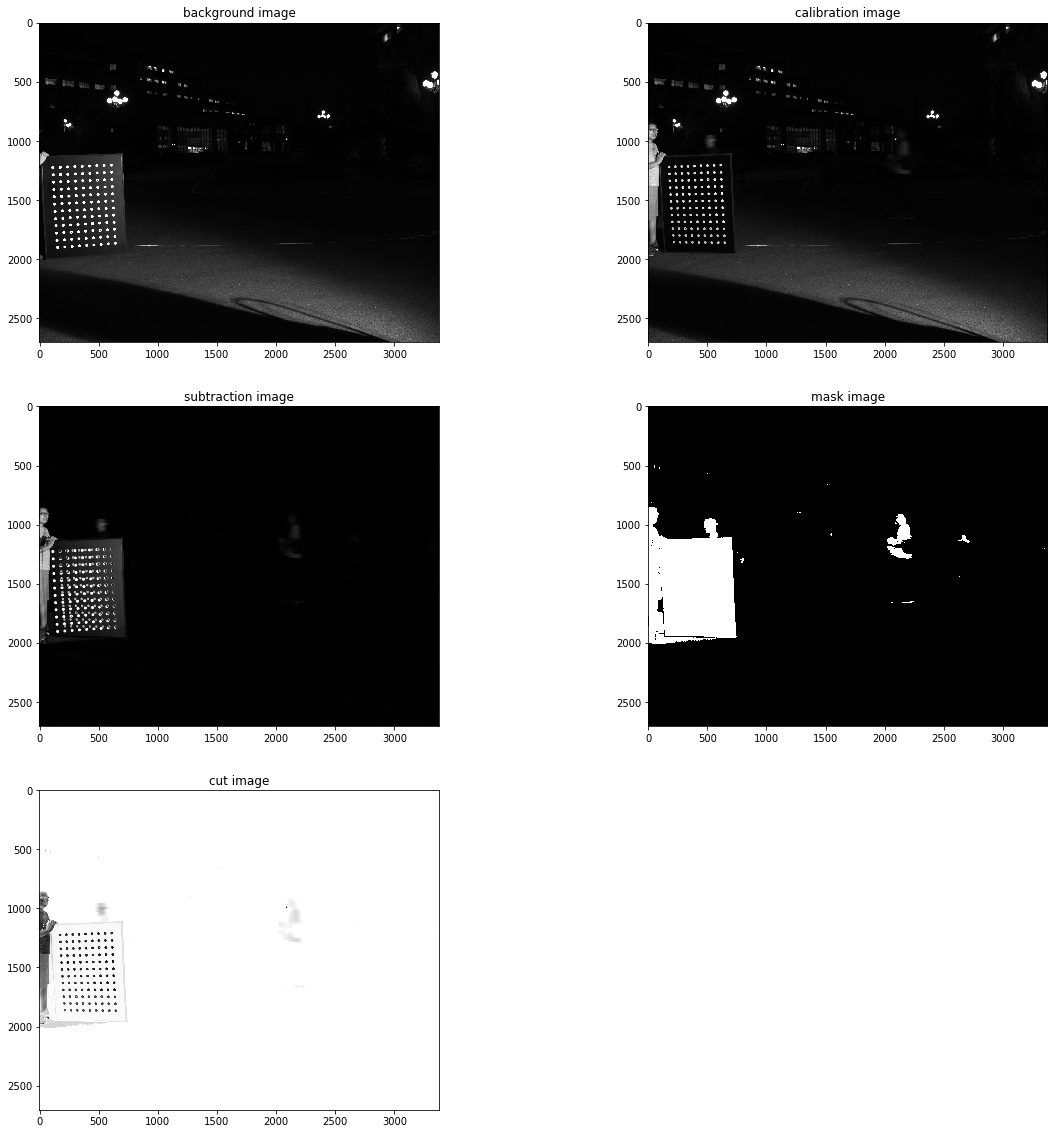

In [55]:
plt.figure(figsize = (20,20))
plt.subplot(321)
plt.imshow(img1, cmap = 'gray')
plt.title('background image')
plt.subplot(322)
plt.imshow(img0, cmap = 'gray')
plt.title('calibration image')
plt.subplot(323)
plt.imshow(filter_sub_img, cmap = 'gray')
plt.title('subtraction image')
plt.subplot(324)
plt.imshow(index_img, cmap = 'gray')
plt.title('mask image')
plt.subplot(325)
plt.imshow(new_img0, cmap = 'gray')
plt.title('cut image')
plt.show()

In [137]:
def plot_detail(src, x,y,w,h):
    plt.figure(figsize=(10,8))
    plt.imshow(src, cmap='gray')
    plt.title('image with circle grid')
    plt.xlim([x,x+w])
    plt.ylim([y+h, y])
    plt.show()

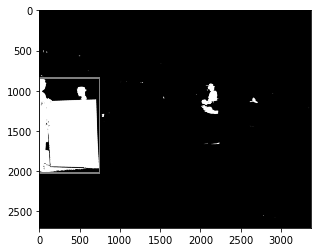

1175 752
minus value: [28.48484848  5.6969697 ]


In [180]:
kernel1 = np.ones([7,7], np.float32)/49
filter_index_img = cv.filter2D(index_img.copy(),-1,kernel1)
filter_index_img = cv.filter2D(filter_index_img.copy(), -1, kernel)
filter_index_img = cv.filter2D(filter_index_img.copy(), -1, kernel)
filter_index_img = cv.filter2D(filter_index_img.copy(), -1, kernel)

cnt = find_max_contour(filter_index_img, 'area')
x,y,w,h = cv.boundingRect(cnt)
patternSize = [9,12]
if w < h:
    patternSize = sorted(patternSize, reverse=True)
else:
    patternSize = sorted(patternSize)
print(h,w)

min_dist = np.min(np.array([h,w])/(np.array(patternSize)+2))/1.5
min_radii = min_dist/8
min_value = np.array([min_dist/1.6, min_radii])

print('minus value:',min_value)

detect 105 blobs


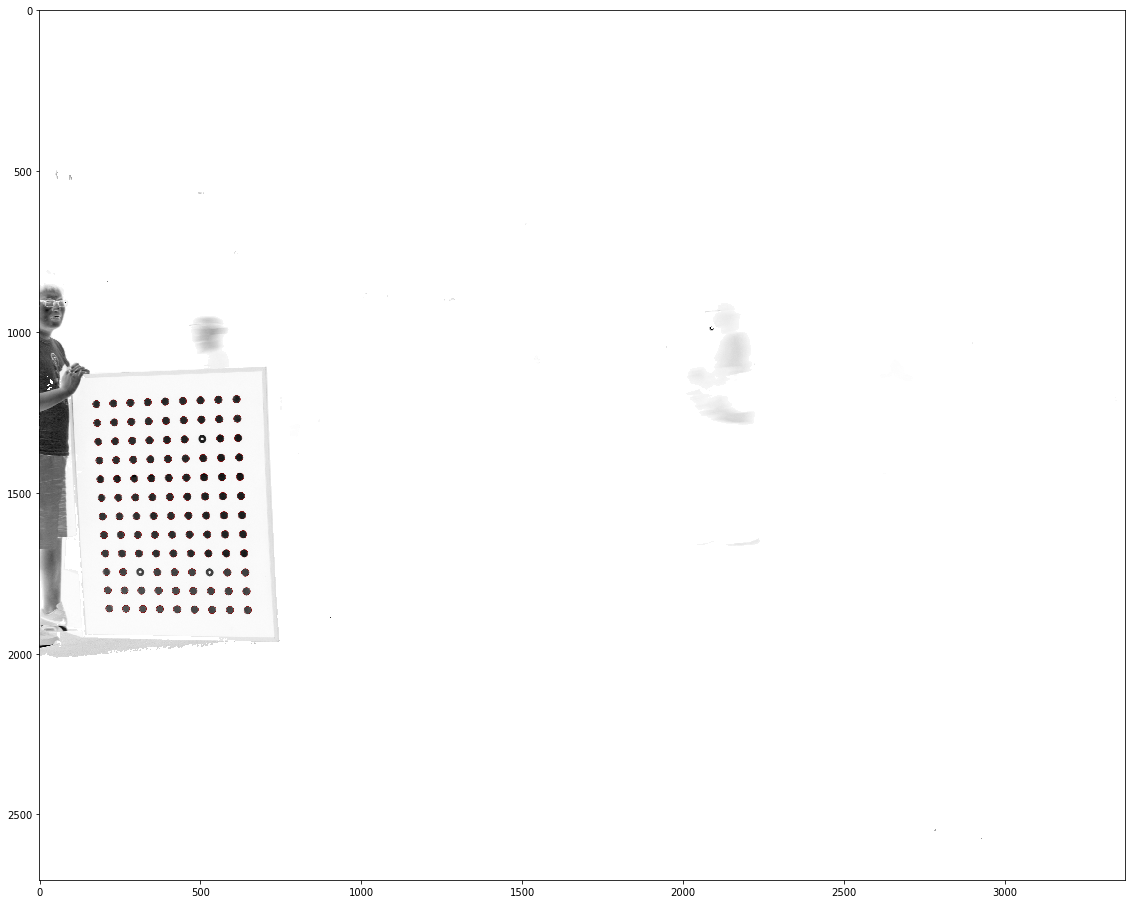

In [187]:
keypoints = find_blob(new_img0.copy())

In [183]:
points_coord = []
points_space = []
for keypoint in keypoints:
    points_coord.append(keypoint.pt)
    points_space.append(keypoint.size)

min_radii = (np.mean(points_space) - 3*np.std(points_space))/2
min_radii

11.361767387582276

find (108, 3) circles


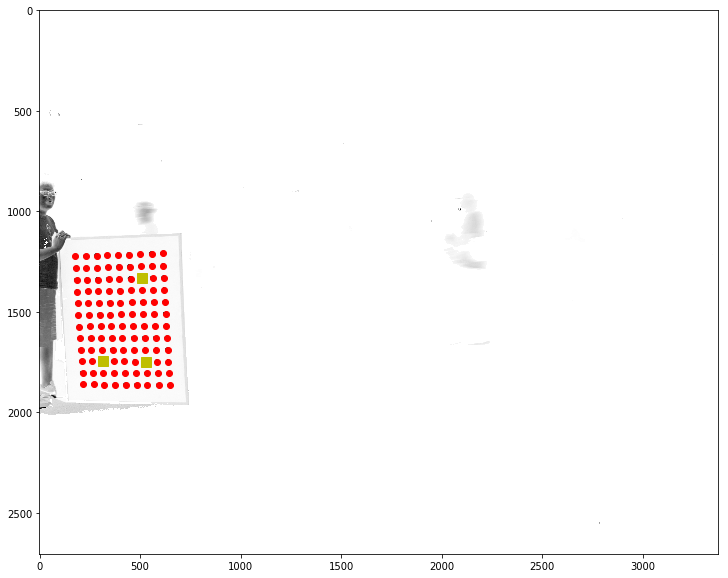

In [184]:
def fill_con_circle(src0, min_value = None):
    
    kernel = np.ones([5,5], np.float32)/25
    #src0 = cv.filter2D(src0.copy(), -1, kernel)
    
    if min_value is None:
        circles0 = cv.HoughCircles(src0, cv.HOUGH_GRADIENT, dp = 1, minDist = 30.0, param1 = 100, param2 = 20, minRadius = 8, maxRadius = 20)
    else:
        min_value = np.array(min_value).astype('int')
        circles0 = cv.HoughCircles(src0, cv.HOUGH_GRADIENT, dp = 1, 
                                   minDist = min_value[0], param1 = 100, param2 = 20, minRadius = min_value[1], maxRadius = 20)
            
    if circles0 is None:
        print('failed')
        return None, None
    else:
        circles0 = np.squeeze(circles0)
        print('find', circles0.shape, 'circles')
    
    int_center_coord = circles0.astype('int')
    int_center_x = int_center_coord[:,0]
    int_center_y = int_center_coord[:,1]
    center_intensity = src0[int_center_y, int_center_x]

    indice = np.argsort(center_intensity)
    mean_intensity = np.mean(center_intensity)

    if mean_intensity < center_intensity[indice[-1]]:
        con_circle_center = circles0[indice[:-4:-1],:2]
    elif mean_intensity > center_intensity[indice[0]]:
        con_circle_center = circles0[indice[:3],:2]

    #print(int(np.mean(int_center_coord[:,2])/2))
    #print(center_intensity)
    #print(con_circle_center)
    
    plt.figure(figsize = (20, 10))
    plt.imshow(src0, cmap = 'gray')
    plt.plot(circles0[:,0], circles0[:,1],'ro' )
    plt.plot(con_circle_center[:,0], con_circle_center[:,1], 'ys', markersize = 10 )
    #plt.xlim([x,x+w])
    #plt.ylim([y+h, y])
    plt.show()
    
    
    point_color = (mean_intensity)
    thickness = -1
    radii = int(np.mean(int_center_coord[:,2])/5*4)

    for center in con_circle_center:
        src0 = cv.circle(src0, (center[0],center[1]), radii, point_color, thickness)
    
    return src0, con_circle_center

src0, con_circle_center = fill_con_circle(new_img0.copy(), [min_dist, min_radii])

In [178]:
def find_circles_grid(src, grid_space, plot_flag = False):
    
    # Setup SimpleBlobDetector parameters.
    params = cv.SimpleBlobDetector_Params()

    # Change thresholds
    #params.thresholdStep = 5
    #params.minThreshold = 10
    #params.maxThreshold = 250

    # Filter by Area.
    params.filterByArea = True
    params.minArea = 200
    params.maxArea = 100000
    
    # Filter by Circularity
    params.filterByCircularity = True
    params.minCircularity = 0.5

    # Filter by Convexity
    params.filterByConvexity = True
    params.minConvexity = 0.5

    # Filter by Inertia
    params.filterByInertia = True
    params.minInertiaRatio = 0.5

    detector = cv.SimpleBlobDetector_create(params)
    
    #patternSize = (9,12)
    isFound, centers = cv.findCirclesGrid(src, grid_space, flags=cv.CALIB_CB_SYMMETRIC_GRID+cv.CALIB_CB_CLUSTERING, blobDetector = detector)

    if isFound:
        print('find', centers.shape[0], 'circles') 
    else:
        print('failed to find circles')

    cv.drawChessboardCorners(src, grid_space, centers, isFound)
    
    if plot_flag:
        plt.figure(figsize = (20,10))
        plt.imshow(src, cmap = 'gray')
        plt.show()
    
    return src, np.squeeze(centers)

src0_grid, image_points = find_circles_grid(src0.copy(), tuple(patternSize))

find 108 circles
